Segment dome/center: length=7.9m, num_clusters=32, num_leds=230


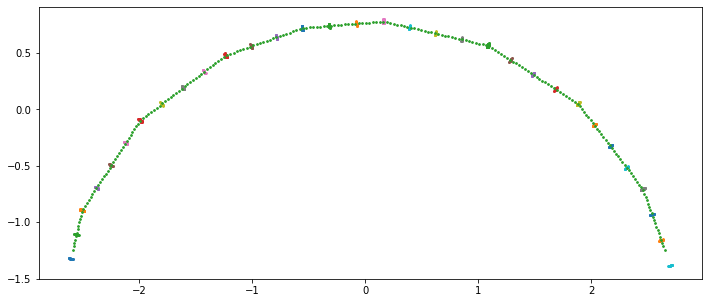

Segment dome/left: length=7.9m, num_clusters=43, num_leds=230


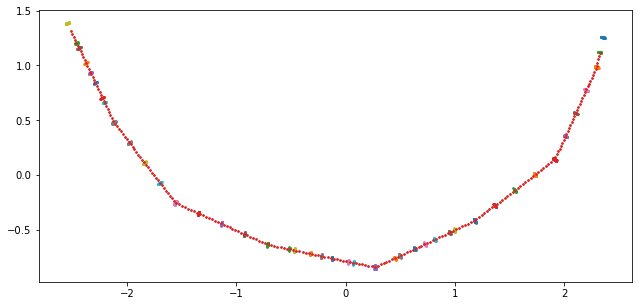

Segment dome/right: length=7.9m, num_clusters=43, num_leds=230


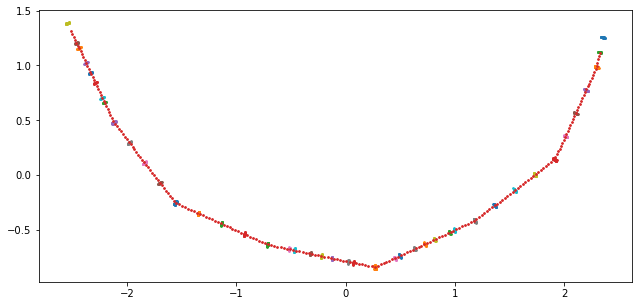

Segment trunk/Body1: length=5.0m, num_clusters=454, num_leds=150


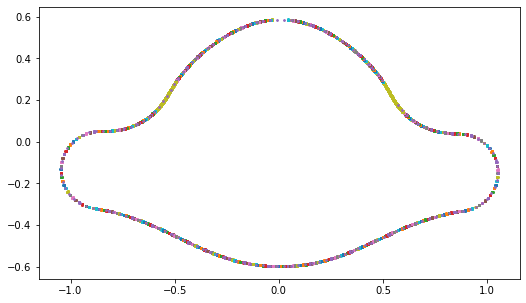

Segment trunk/Body2: length=3.3m, num_clusters=281, num_leds=98


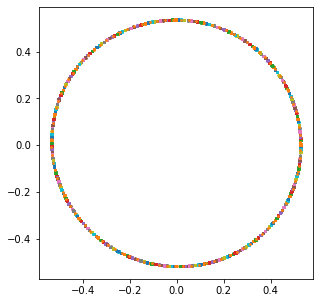

Segment trunk/Body3: length=3.0m, num_clusters=293, num_leds=91


In [8]:
import csv
from distutils.log import error 
import json
import math
import numpy as np

import led_config_utils
import mesh_config
from funky_lights import wavefront, led_config

from importlib import reload
reload(mesh_config)

LED_ID_MAPPING_RIGHT = np.array([
    [-1,  -1,  -1,   4,   3,   2,   1,   0,  -1,  -1,  -1],
    [-1,  -1,   5,   6,   7,   8,   9,  10,  11,  -1,  -1],
    [-1,  20,  19,  18,  17,  16,  15,  14,  13,  12,  -1],
    [21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31],
    [42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32],
    [43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53],
    [64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54],
    [65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75],
    [-1,  84,  83,  82,  81,  80,  79,  78,  77,  76,  -1],
    [-1,  -1,  85,  86,  87,  88,  89,  90,  91,  -1,  -1],
    [-1,  -1,  -1,  96,  95,  94,  93,  92,  -1,  -1,  -1]
])
LED_ID_MAPPING_RIGHT = np.rot90(LED_ID_MAPPING_RIGHT)

LED_ID_MAPPING_LEFT = np.array([
    [-1,  -1,  -1,  59,  58,  37,  36,   9,  -1,  -1,  -1],
    [-1,  -1,  78,  60,  57,  38,  35,   8,  10,  -1,  -1],
    [-1,  79,  77,  61,  56,  39,  34,   7,  11,   0,  -1],
    [90,  80,  76,  62,  55,  40,  33,   6,  12,   1,  -1],
    [89,  81,  75,  63,  54,  41,  32,   5,  13,   2,  -1],
    [88,  82,  74,  64,  53,  42,  31,   4,  14,  -1,  -1],
    [87,  83,  73,  65,  52,  43,  30,   3,  15,  21,  -1],
    [86,  84,  72,  66,  51,  44,  29,  22,  16,  20,  -1],
    [-1,  85,  71,  67,  50,  45,  28,  23,  17,  19,  -1],
    [-1,  -1,  70,  68,  49,  46,  27,  24,  18,  -1,  -1],
    [-1,  -1,  -1,  69,  48,  47,  26,  25,  -1,  -1,  -1]
])
LED_ID_MAPPING_LEFT = np.rot90(LED_ID_MAPPING_LEFT)

all_segments = {}
for config in mesh_config.mesh_configs:
    # if config.mesh != '../controller/mesh/eyes.obj':
    #     continue
    mesh = wavefront.load_obj(config.mesh)
    with open(config.actual_csv, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        segments=[]

        for row in reader:
            uid = int(row[0])
            name = row[1]
            actual_num_leds = int(row[2])
            actual_length = float(row[3])
            reverse = (row[4] == 'TRUE')
            
            for group in mesh.groups:
                if group.name == name:
                    break

            group = next((g for g in mesh.groups if g.name == name), None)
            if not group:
                print("Couldn't find mesh group for %s" % name)
                continue

            data = led_config_utils.prepare_data(group)
            data_2d, U, mu = led_config_utils.pca(data)
            clusters, labels = led_config_utils.cluster(
                data_2d, eps=config.cluster_eps, min_samples=3)

            nodes = led_config_utils.create_line_segments(data, clusters, labels)
            modelled_length = led_config_utils.line_segments_length(nodes)
            modelled_length = modelled_length -  config.start_offset -  config.end_offset
            if nodes == None:
                continue
            leds_distance = modelled_length / actual_num_leds
            points = led_config_utils.trace_line_segments(nodes, actual_num_leds, config.start_offset, leds_distance)

            if name == 'head/right_eye' or name == 'head/left_eye':
                # Select mapping
                if name == 'head/right_eye':
                    led_id_mapping = LED_ID_MAPPING_RIGHT
                elif name == 'head/left_eye':
                    led_id_mapping = LED_ID_MAPPING_LEFT
                else:
                    error("Should never get here.")
                
                points_2d = np.dot(points - mu, U.T)
                grid_size = 11
                center = points_2d.mean(0)
                radius = np.linalg.norm(points_2d - center, axis=1).mean()
                step_size = (radius * 2) / grid_size
                offset = math.floor(grid_size / 2) * step_size
                x0 = center[0] - offset
                y0 = center[1] - offset

                segment_points = []
                segment_ids = []
                for r in range(grid_size):
                    row = []
                    y_pos = y0 + r * step_size
                    for c in range(grid_size):
                        x_pos = x0 + c * step_size 
                        id = led_id_mapping[grid_size - 1 - r][c]
                        if id >= 0:
                            segment_ids.append(id)
                            segment_points.append(np.array([x_pos, y_pos, 0]))
                            # print("%d %d %d" % (id, r, c))

                zipped_pairs = zip(segment_ids, segment_points)
                points = np.array([x for _, x in sorted(zipped_pairs)])
                # Transform points back into 3D coordinates
                points = np.dot(points, U) + mu
            
            if len(points) == 0:
                continue

            if reverse:
                points = np.flip(points, axis=0)

            segment = led_config.Segment(
                uid=uid, name=group.name, points=points, num_leds=points.shape[0], length=actual_length)
            print('Segment %s: length=%.1fm, num_clusters=%s, num_leds=%s' %
                  (segment.name, segment.length, len(clusters), segment.num_leds))
            segments.append(segment)
            all_segments[uid] = segment
            # led_config_utils.plot_segment(data, clusters, labels, points)

# Collapse some segments
UIDS_TRUNK = [10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
UIDS_TUSKS_RIGHT = [25,26,27,28,29,30,31,32,33,34,35]
UIDS_TUSKS_LEFT = [36,3,38,39,40,41,42,43,44,45,46]
for merge_list in [UIDS_TRUNK, UIDS_TUSKS_RIGHT, UIDS_TUSKS_LEFT]:
    merged_segment = all_segments[merge_list[0]]
    for uid in merge_list[1:]:
        segment = all_segments.pop(uid)
        merged_segment.merge(segment)

# Create LED config
config = led_config.LedConfig()
for segment in all_segments.values():
    config.led_segments.append(segment)
    config.total_num_segments += 1
    config.total_length += segment.length
    config.total_num_leds += segment.num_leds

with open('../config/led_config.json', 'w', encoding='utf-8') as f:
    json.dump(config.to_dict(), f, ensure_ascii=False, indent=4)

